# Modeling Marketing Mix using Smoothing Splines
## Capturing non-linear saturation and diminishing returns without explicitly transforming media variables
Slava Kisilevich
kisilevich.slava@gmail.com

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import sys
import os


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns

from plotnine import *


import plotly.io as pio
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'


from IPython.core.debugger import set_trace

In [3]:
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [206]:
from pygam import LinearGAM, s, l, intercept
from pygam.terms import SplineTerm

In [5]:
import shap
shap.initjs()

In [6]:
from sklearn.model_selection import TimeSeriesSplit

In [7]:
from prophet import Prophet

In [8]:
from functools import partial
import optuna as opt

In [9]:
START_ANALYSIS_INDEX = 52
END_ANALYSIS_INDEX = 144

## Data

In [10]:
data = pd.read_csv("./data/data_raw_2015-11-23__2019-11-11.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000


In [11]:
holidays = pd.read_csv("./data/prophet_holidays_daily.csv", parse_dates = ["ds"])
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [12]:
prophet_data = data.rename(columns = {'revenue': 'y', 'date': 'ds'})
#add categorical into prophet
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet_data

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385,0,1
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000,0,1
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000,0,1
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000,0,1
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000,0,1
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000,0,1
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000,0,1
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000,0,1


In [13]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_de)
prophet.add_regressor(name = "events_event2")
prophet.add_regressor(name = "events_na")

In [14]:
prophet.fit(prophet_data[["ds", "y", "events_event2", "events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "events_event2", "events_na"]])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


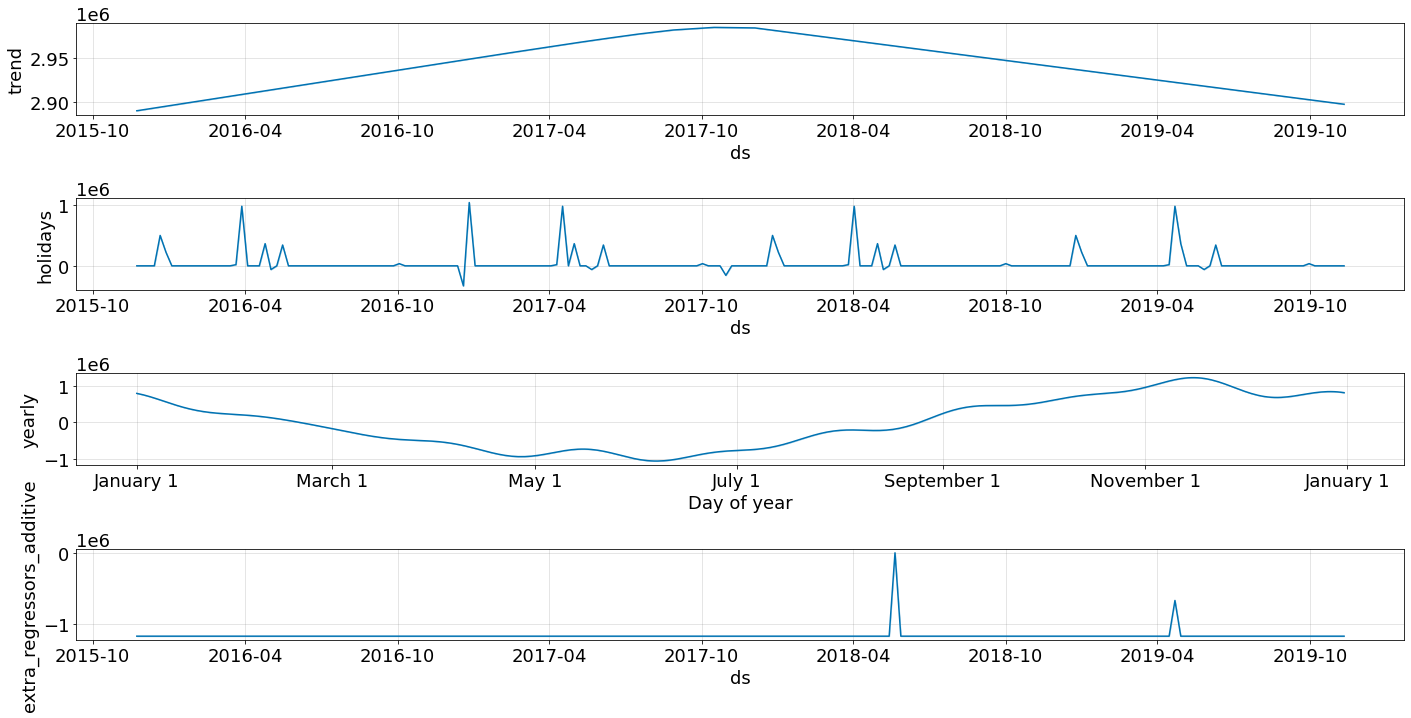

In [15]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [16]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)


final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

## Non-linear modeling

In [17]:
data.iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
52,2016-11-21,2964696.66667,52177.90000,271909,54698.00000,80485549.89262,0.00000,0,9029457,200462.81552,na,19401.65385
53,2016-11-28,2848525.00000,0.00000,0,31072.00000,53736753.49765,73955.95632,71500,9334174,141956.39115,na,27941.00000
54,2016-12-05,2740160.00000,106908.00000,448276,0.00000,21469926.03224,65123.98793,63000,8234498,49694.03594,na,51273.00000
55,2016-12-12,2380508.33333,0.00000,0,0.00000,29472934.60218,52768.86061,55100,7904539,90910.83720,na,19606.00000
56,2016-12-19,2230915.00000,0.00000,627975,0.00000,14122124.68989,47686.78427,51700,7127441,30356.33075,na,4453.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
139,2018-07-23,1479303.33333,72966.70000,0,38795.00000,0.00000,47370.36869,51900,4606123,0.00000,na,22477.00000
140,2018-07-30,1647193.33333,0.00000,0,0.00000,0.00000,77832.99757,58100,5494567,0.00000,na,8906.00000
141,2018-08-06,2009478.33333,97811.20000,173577,54001.00000,0.00000,76885.47655,65800,6045317,0.00000,na,59318.00000
142,2018-08-13,1523443.33333,0.00000,0,0.00000,54622076.09755,0.00000,0,5035305,133522.51163,na,19401.65385


In [18]:
data = final_data

In [19]:
target = "revenue"
base_features = ["trend", "season", "holiday", "competitor_sales_B", "events"]
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
features = base_features + media_channels + organic_channels

<AxesSubplot:>

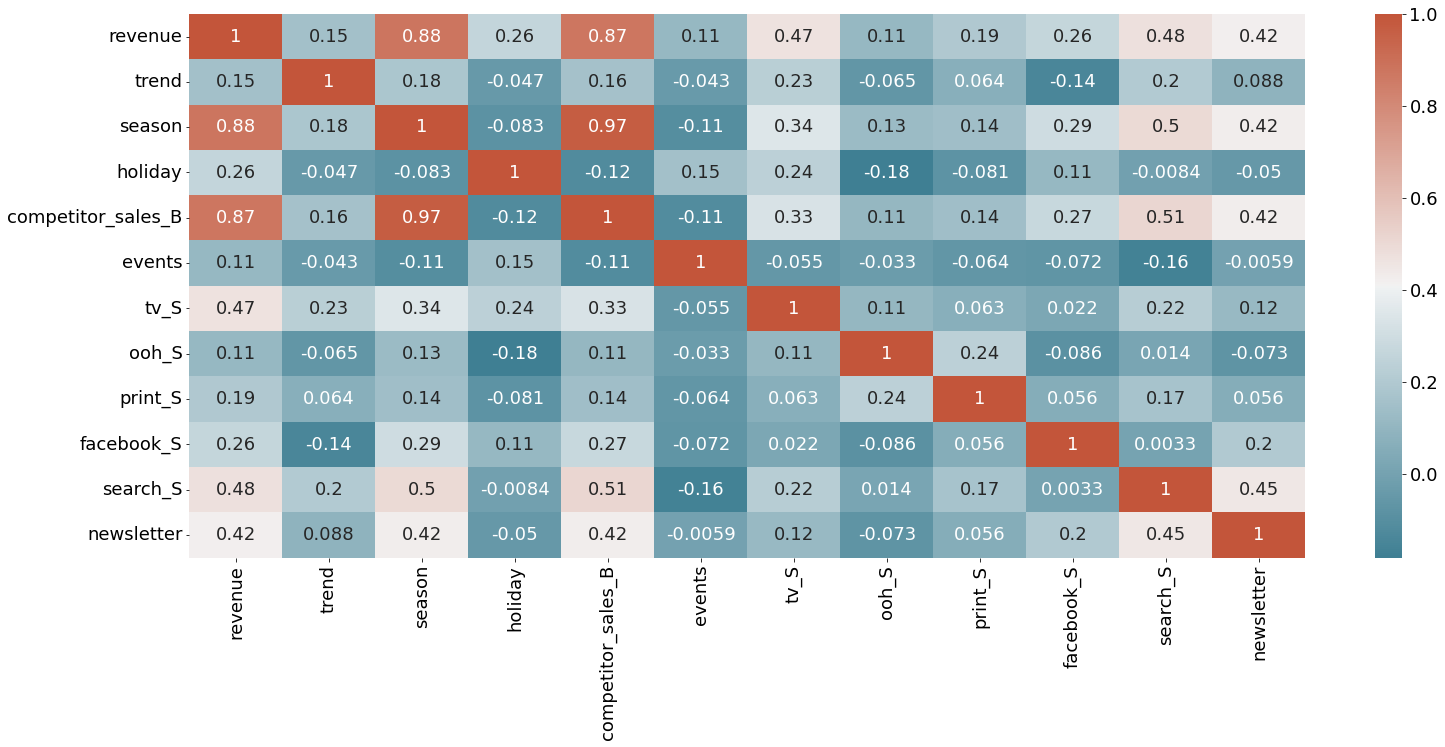

In [20]:
corr = data.loc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX - 1, [target] + features].corr()


fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

## Helper Functions

In [248]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        return self
    
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]
        
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha* x_decayed[xi - 1]
        return x_decayed
    
def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

#https://github.com/facebookexperimental/Robyn
def rssd(effect_share, spend_share):
    """RSSD decomposition
    
    Decomposition distance (root-sum-square distance, a major innovation of Robyn) 
    eliminates the majority of "bad models" 
    (larger prediction error and/or unrealistic media effect like the smallest channel getting the most effect

    Args:
        effect_share ([type]): percentage of effect share
        spend_share ([type]): percentage of spend share

    Returns:
        [type]: [description]
    """
    return np.sqrt(np.sum((effect_share - spend_share) ** 2))


def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    """Spend vs Effect Share plot

    Args:
        decomp_spend (pd.DataFrame): Data with media decompositions. The following columns should be present: media, spend_share, effect_share per media variable
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).

    Example:
        decomp_spend:
        media         spend_share effect_share
        tv_S           0.31        0.44
        ooh_S          0.23        0.34
    
    Returns:
        [plotnine]: plotnine plot
    """
    
    plot_spend_effect_share = decomp_spend.melt(id_vars = ["media"], value_vars = ["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill = "variable")) \
    + geom_bar(stat = "identity", position = "dodge") \
    + geom_text(aes(label = "value * 100", group = "variable"), color = "darkblue", position=position_dodge(width = 0.5), format_string = "{:.2f}%") \
    + coord_flip() \
    + ggtitle("Share of Spend VS Share of Effect") + ylab("") + xlab("") \
    + theme(figure_size = figure_size, 
                    legend_direction='vertical', 
                    legend_title=element_blank(),
                    legend_key_size=20, 
                    legend_entry_spacing_y=5) 
    return plt


def calculate_spend_effect_share(gam_term_response_values: pd.DataFrame, media_channels, df_original: pd.DataFrame):
    """
    Args:
        gam_term_response_values: data frame with gam term function values
        media_channels: list of media channel names
        df_original: non transformed original data
    Returns: 
        [pd.DataFrame]: data frame with spend effect shares
    """
    
    media_channels_y = [f"{channel}_y" for channel in media_channels]
    responses = pd.DataFrame(gam_term_response_values[media_channels_y].abs().sum(axis = 0), columns = ["effect_share"])
    response_percentages = responses / responses.sum()
    #substitute back the original names
    response_percentages.index = media_channels
    response_percentages

    spends_percentages = pd.DataFrame(df_original[media_channels].sum(axis = 0) / df_original[media_channels].sum(axis = 0).sum(), columns = ["spend_share"])
    spends_percentages

    spend_effect_share = pd.merge(response_percentages, spends_percentages, left_index = True, right_index = True)
    spend_effect_share = spend_effect_share.reset_index().rename(columns = {"index": "media"})
    
    return spend_effect_share


In [249]:
def build_gam_formula(data, 
                      base_features, 
                      smooth_features, 
                      n_splines = 20):
    
    #set the first spline term
    channel_index = data.columns.get_loc(smooth_features[0])
    formula = s(channel_index, 
                n_splines, 
                constraints='monotonic_inc')
    
    for smooth_channel in smooth_features[1:]:
        channel_index = data.columns.get_loc(smooth_channel)

        #smooth term
        formula = formula + s(channel_index, 
                              n_splines, 
                              constraints='monotonic_inc')

    for base_feature in base_features:
        feature_index = data.columns.get_loc(base_feature)

        #linear term
        formula = formula + l(feature_index)

    
    return formula


In [250]:
def optuna_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features,
                 base_features, 
                 adstock_features, 
                 adstock_features_params, 
                 media_features, 
                 tscv, 
                 n_splines = 10):
    
    data_temp = data.copy()
    adstock_alphas = {}
    
    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_uniform(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha
        
        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_temp[feature] = temp_adstock
        
        
    gam_lambda_dict = {}
    gam_lambda_list = []
    #probably not optimal when there are linear terms. 
    #alternative approach is to iterate through the terms of the formula itself and optimize the smooting terms only. 
    #linear terms would get a constant lambda
    for feature in features:
        gam_lambda = trial.suggest_float(f"{feature}_gam_lambda", 0.1, 1000)
        gam_lambda_dict[feature] = gam_lambda
        gam_lambda_list.append(gam_lambda)
        
    gam_formula = build_gam_formula(data_temp[features], base_features, adstock_features, n_splines = n_splines)
    
    scores = []
    
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]
        
        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]
        
        #save lambdas as dictionary and as a list
        params = {"lambda": gam_lambda_dict, 
                  "lambda_list": gam_lambda_list
                 }
        
        gam_model = LinearGAM(gam_formula, lam = gam_lambda_list).fit(x_train.values, y_train)
        
        prediction = gam_model.predict(x_test.values)
        
        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)
        
    trial.set_user_attr("scores", scores)
    
    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)
    trial.set_user_attr("gam_lambda", gam_lambda_dict)
    trial.set_user_attr("gam_formula", gam_formula)
    
    return np.mean(scores)


In [254]:
def optuna_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    base_features,
                    adstock_features, 
                    adstock_features_params, 
                    media_features, 
                    tscv, 
                    n_splines = 10, 
                    seed = 42):
    print(f"data size: {len(data)}")
    print(f"media features: {media_features}")
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")
    print(f"n_splines: {n_splines}")
    
    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
        
    optimization_function = partial(optuna_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    base_features = base_features,
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    media_features = media_features, 
                                    tscv = tscv, 
                                    n_splines = n_splines)
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm
    

In [255]:
def model_refit(data, 
                target,
                formula, 
                features, 
                base_features, 
                media_channels, 
                organic_channels, 
                lambda_params, 
                adstock_params,
                
                start_index, 
                end_index, 
                n_splines = 10, 
                force_gam_gridsearch = False):
    """refits the model on the data constrained by start and end indices

    Args:
        data (pd.DataFrame): 
        target (str): 
        features (List[str]):  
        base_features (List[str]):  
        media_channels (List[str]):  
        organic_channels (List[str]):   
        model_params 
        adstock_params, 
        start_index (int): 
        end_index (int):

    
    Returns:
        
    """
    
    data_refit = data.copy()

    best_params = lambda_params
    best_gam_lambda = best_params["lambda_list"]
    
    print(f"using GAM formula: {formula}")
    print(f"using GAM lambda: {best_gam_lambda}")
    
    adstock_alphas = adstock_params
    
    adstock_features = media_channels + organic_channels
    
    gam_formula = formula

    #apply adstock transformation
    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_refit[feature] = temp_adstock

    #build the final model on the data constrained by start and end index
    x_input = data_refit.loc[start_index:end_index-1, features]
    y_true = data[target].values[start_index:end_index]

    #build GAM using the best parameters
    
    if force_gam_gridsearch == False:
        gam_model = LinearGAM(gam_formula, lam = best_gam_lambda).fit(x_input.values, y_true)
    else:
        print("forcing grid search on GAM lambda...")
        gam_model = LinearGAM(gam_formula).gridsearch(x_input.values, y_true)
        
    prediction = gam_model.predict(x_input.values)

    x_input_interval_transformed = x_input
    #transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]
    
    #extract response per gam term:
    gam_term_response_functions = pd.DataFrame()
    for i, channel in enumerate(media_channels + organic_channels):
        feature_index = data[features].columns.get_loc(channel)
        print(f"index: {i} => {channel} => index in data {feature_index}")
        #it is tricky:
        #so we generate X grid for the terms starting at position 0 in the same order as formula was built (media_channels + organic_channels)
        XX = gam_model.generate_X_grid(term=i)

        #but we reference it with feature_index corresponding to the place in the data
        channel_x = XX[:, feature_index]

        #partial dependence for the term i
        term_function = gam_model.partial_dependence(term=i, X=XX)

        gam_term_response_functions = pd.concat([gam_term_response_functions, 
                                                 pd.DataFrame(channel_x, columns = [f"{channel}_x"]), 
                                                 pd.DataFrame(term_function, columns = [f"{channel}_y"])], 
                                                axis = 1)


    return {
            'gam_term_response_values': gam_term_response_functions, 
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true, 
            'model': gam_model,
            'gam_formula': gam_formula
           }

In [253]:
def plot_gam_response_vs_spend(term_response_values, 
                               x_input_interval_nontransformed, 
                               x_input_interval_transformed, 
                               features, 
                               media_channels, 
                               figsize=(25, 10)):
    for channel in media_channels:
    
        #index = features.index(channel)

        mean_spend = x_input_interval_nontransformed.loc[x_input_interval_nontransformed[channel] > 0, channel].mean()

        fig, ax = plt.subplots(figsize=figsize)
        
        x = f"{channel}_x"
        y = f"{channel}_y"
        sns.regplot(x = term_response_values[x], y = term_response_values[y], label = channel,
                    scatter_kws={'alpha': 0.65}, line_kws={'color': 'C2', 'linewidth': 6},
                    fit_reg = False, lowess=True, ax=ax).set(title=f'{channel}: Spend vs Response')
        ax.axhline(0, linestyle = "--", color = "black", alpha = 0.5)
        ax.axvline(mean_spend, linestyle = "--", color = "red", alpha = 0.5, label=f"Average Spend: {int(mean_spend)}")
        ax.set_xlabel(f"{channel} spend")
        ax.set_ylabel(f'GAM Term Response for {channel}')
        plt.legend()

## Modeling with pyGAM

In [270]:
tscv = TimeSeriesSplit(n_splits=3, test_size = 20)

adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = (0.3, 0.8)
adstock_features_params["ooh_S_adstock"] = (0.1, 0.4)
adstock_features_params["print_S_adstock"] = (0.1, 0.4)
adstock_features_params["facebook_S_adstock"] = (0.0, 0.4)
adstock_features_params["search_S_adstock"] = (0.0, 0.3)
adstock_features_params["newsletter_adstock"] = (0.1, 0.4)

#
OPTUNA_TRIALS = 120
experiment = optuna_optimize(trials = OPTUNA_TRIALS, 
                             data = data, 
                             target = target, 
                             features = features,
                             base_features = base_features,
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             media_features=media_channels, 
                             tscv = tscv, 
                             n_splines = 10)

data size: 208
media features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
n_splines: 10


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/12000 [00:00<?, ?it/s]

In [271]:
experiment.best_trial.user_attrs["gam_formula"]

s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + l(0) + l(1) + l(2) + l(3) + l(4)

In [272]:
experiment.best_trial.user_attrs["scores"]

[107792.60911007196, 124412.35199204956, 47341.396107710905]

In [273]:
experiment.best_trial.user_attrs["params"]

{'lambda': {'trend': 34.05462734194995,
  'season': 697.3286367681387,
  'holiday': 17.612468292632343,
  'competitor_sales_B': 0.6015163710636793,
  'events': 981.5411392997992,
  'tv_S': 636.2135990996187,
  'ooh_S': 767.5359415502215,
  'print_S': 914.123220666546,
  'facebook_S': 444.6798727907083,
  'search_S': 657.2024450496322,
  'newsletter': 411.89257286708124},
 'lambda_list': [34.05462734194995,
  697.3286367681387,
  17.612468292632343,
  0.6015163710636793,
  981.5411392997992,
  636.2135990996187,
  767.5359415502215,
  914.123220666546,
  444.6798727907083,
  657.2024450496322,
  411.89257286708124]}

In [274]:
experiment.best_trial.user_attrs["adstock_alphas"]

{'tv_S': 0.3000746801786966,
 'ooh_S': 0.22644049447620745,
 'print_S': 0.39990398503485053,
 'facebook_S': 0.3516887095533137,
 'search_S': 0.013409693426837722,
 'newsletter': 0.11483900946295114}

In [275]:
experiment.best_params

{'adstock_alpha_tv_S': 0.3000746801786966,
 'adstock_alpha_ooh_S': 0.22644049447620745,
 'adstock_alpha_print_S': 0.39990398503485053,
 'adstock_alpha_facebook_S': 0.3516887095533137,
 'adstock_alpha_search_S': 0.013409693426837722,
 'adstock_alpha_newsletter': 0.11483900946295114,
 'trend_gam_lambda': 34.05462734194995,
 'season_gam_lambda': 697.3286367681387,
 'holiday_gam_lambda': 17.612468292632343,
 'competitor_sales_B_gam_lambda': 0.6015163710636793,
 'events_gam_lambda': 981.5411392997992,
 'tv_S_gam_lambda': 636.2135990996187,
 'ooh_S_gam_lambda': 767.5359415502215,
 'print_S_gam_lambda': 914.123220666546,
 'facebook_S_gam_lambda': 444.6798727907083,
 'search_S_gam_lambda': 657.2024450496322,
 'newsletter_gam_lambda': 411.89257286708124}

In [276]:
np.mean(experiment.best_trial.user_attrs["scores"])

93182.11906994414

## Model Refit

In [277]:
best_params = experiment.best_trial.user_attrs["params"]
adstock_params = experiment.best_trial.user_attrs["adstock_alphas"]
formula = experiment.best_trial.user_attrs["gam_formula"]
result = model_refit(data = data, 
                     target = target,
                     formula = formula,
                     features = features, 
                     base_features = base_features, 
                     media_channels = media_channels, 
                     organic_channels = organic_channels, 
                     lambda_params = best_params, 
                     adstock_params = adstock_params, 
                     start_index = START_ANALYSIS_INDEX, 
                     end_index = END_ANALYSIS_INDEX, 
                     force_gam_gridsearch = False, 
                     n_splines = 10)

using GAM formula: s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + l(0) + l(1) + l(2) + l(3) + l(4)
using GAM lambda: [34.05462734194995, 697.3286367681387, 17.612468292632343, 0.6015163710636793, 981.5411392997992, 636.2135990996187, 767.5359415502215, 914.123220666546, 444.6798727907083, 657.2024450496322, 411.89257286708124]
applying geometric adstock transformation on tv_S with alpha 0.3000746801786966
applying geometric adstock transformation on ooh_S with alpha 0.22644049447620745
applying geometric adstock transformation on print_S with alpha 0.39990398503485053
applying geometric adstock transformation on facebook_S with alpha 0.3516887095533137
applying geometric adstock transformation on search_S with alpha 0.013409693426837722
applying geometric adstock transformation on newsletter with alpha 0.11483900946295114
index: 0 => tv_S => index in data 5
index: 1 => ooh_S => index in data 6
index: 2 => print_S => index in data 7
index: 3 => facebook_S => index in data 8
index: 4 => sear

In [278]:
result["model"].summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     13.2519
Link Function:                     IdentityLink Log Likelihood:                                 -2304.2384
Number of Samples:                           92 AIC:                                             4636.9805
                                                AICc:                                             4642.645
                                                GCV:                                      40397593667.5032
                                                Scale:                                    30080127252.9161
                                                Pseudo R-Squared:                                   0.9543
Feature Function                  Lam

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



In [279]:
len(result["model"].coef_)

66

In [280]:
#intercept
result["model"].coef_[-1]

829420.4619628191

## Metrics

RMSE: 160459.68973090965
MAPE: 0.05587866681720123
NRMSE: 0.05207619522095525
R2: 0.9542815351303634


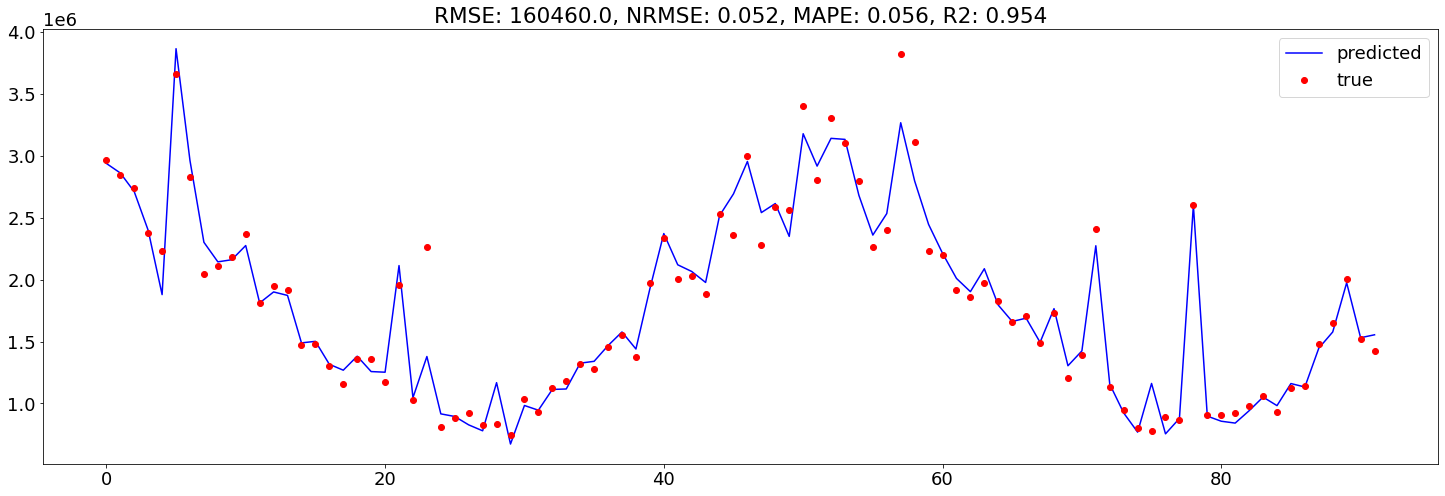

In [281]:
rmse_metric = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])
nrmse_metric = nrmse(result["y_true_interval"], result["prediction_interval"])
r2_metric = r2_score(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])

print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')
print(f'NRMSE: {nrmse_metric}')
print(f'R2: {r2_metric}')


fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(result["prediction_interval"], color = "blue", label = "predicted")
_ = ax.plot(result["y_true_interval"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, NRMSE: {np.round(nrmse_metric, 3)}, MAPE: {np.round(mape_metric, 3)}, R2: {np.round(r2_metric,3)}")
_ = ax.legend()

In [282]:
media_channels_y = [f"{channel}_y" for channel in media_channels]
responses = pd.DataFrame(result["gam_term_response_values"][media_channels_y].abs().sum(axis = 0), columns = ["effect_share"])
response_percentages = responses / responses.sum()
response_percentages

,effect_share
tv_S_y,0.31760
ooh_S_y,0.21595
print_S_y,0.24480
facebook_S_y,0.01400
search_S_y,0.20766


DECOMP.RSSD: 0.2685231892385429


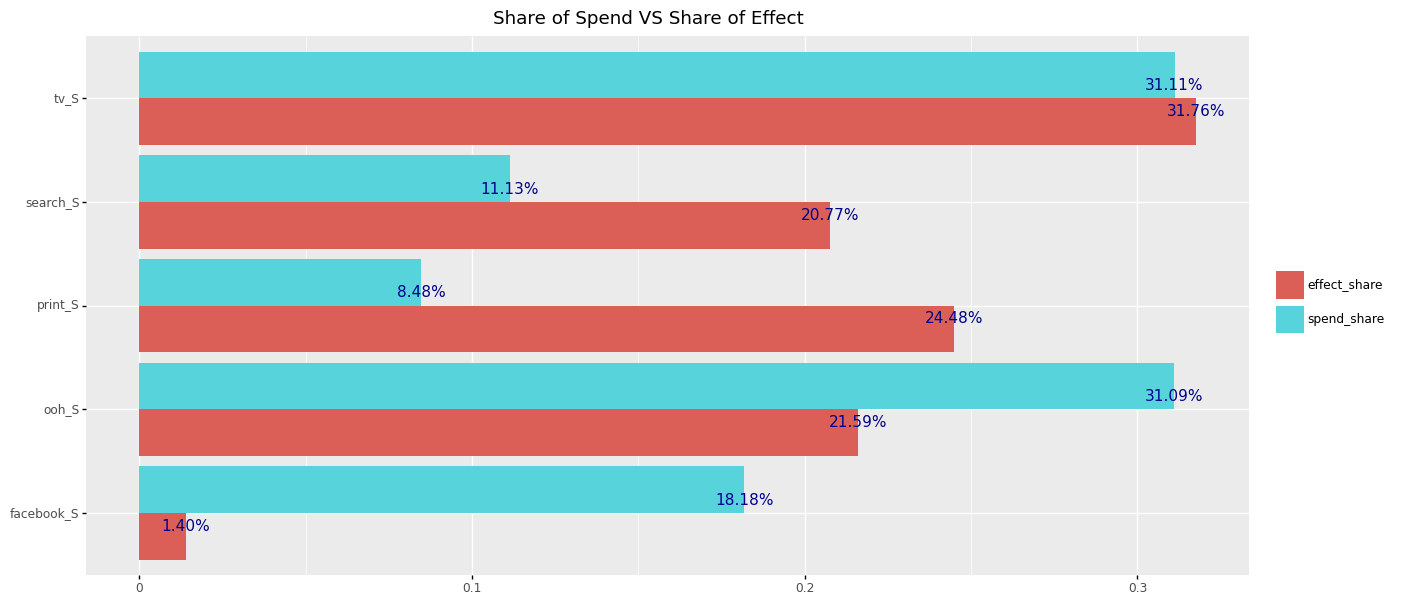

In [283]:
spend_effect_share = calculate_spend_effect_share(gam_term_response_values = result["gam_term_response_values"], 
                                                  media_channels = media_channels, 
                                                  df_original = result["x_input_interval_nontransformed"])

decomp_rssd = rssd(effect_share = spend_effect_share.effect_share.values, spend_share = spend_effect_share.spend_share.values)
print(f"DECOMP.RSSD: {decomp_rssd}")
print(plot_spend_vs_effect_share(spend_effect_share, figure_size = (15, 7)))



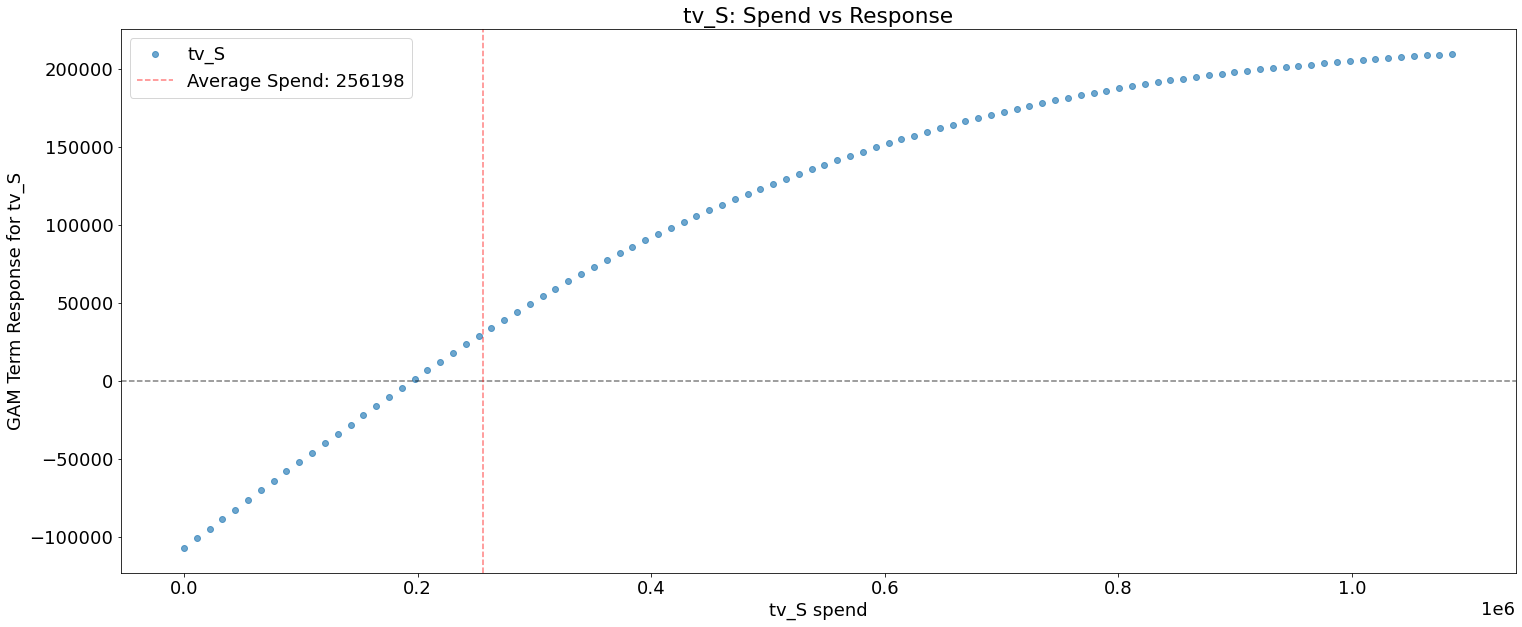

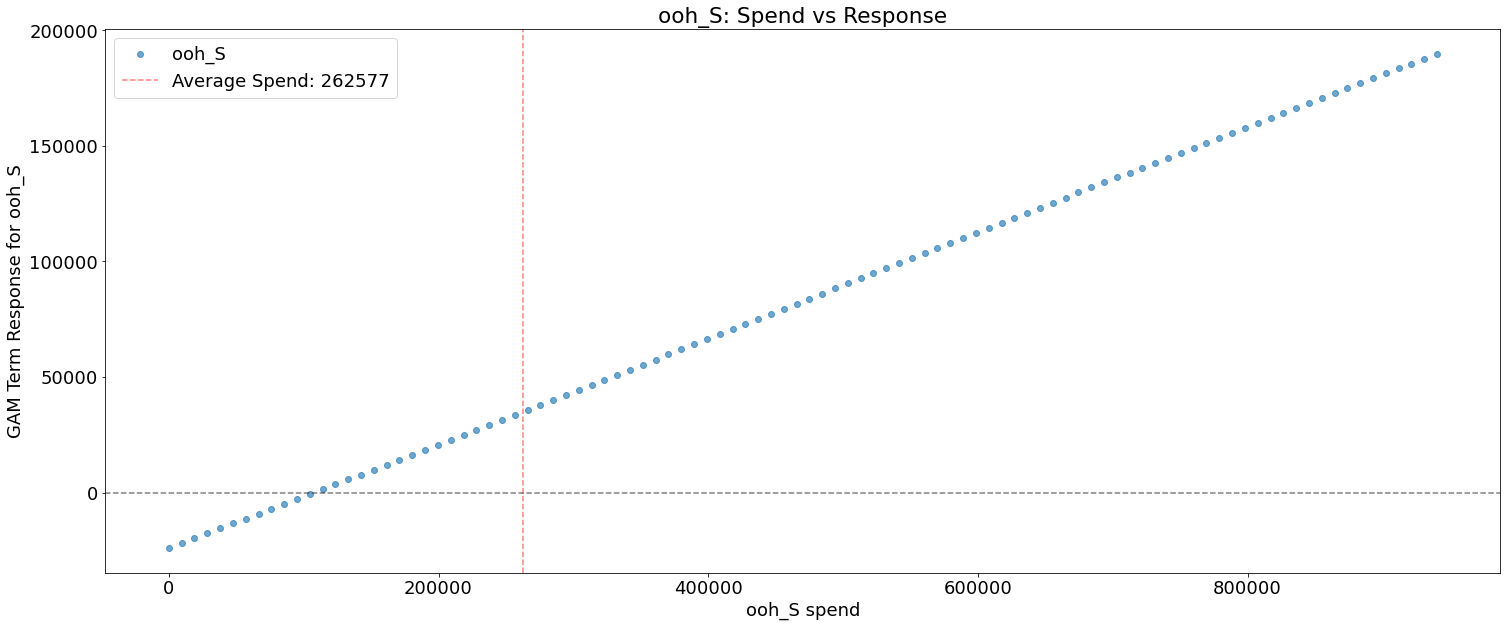

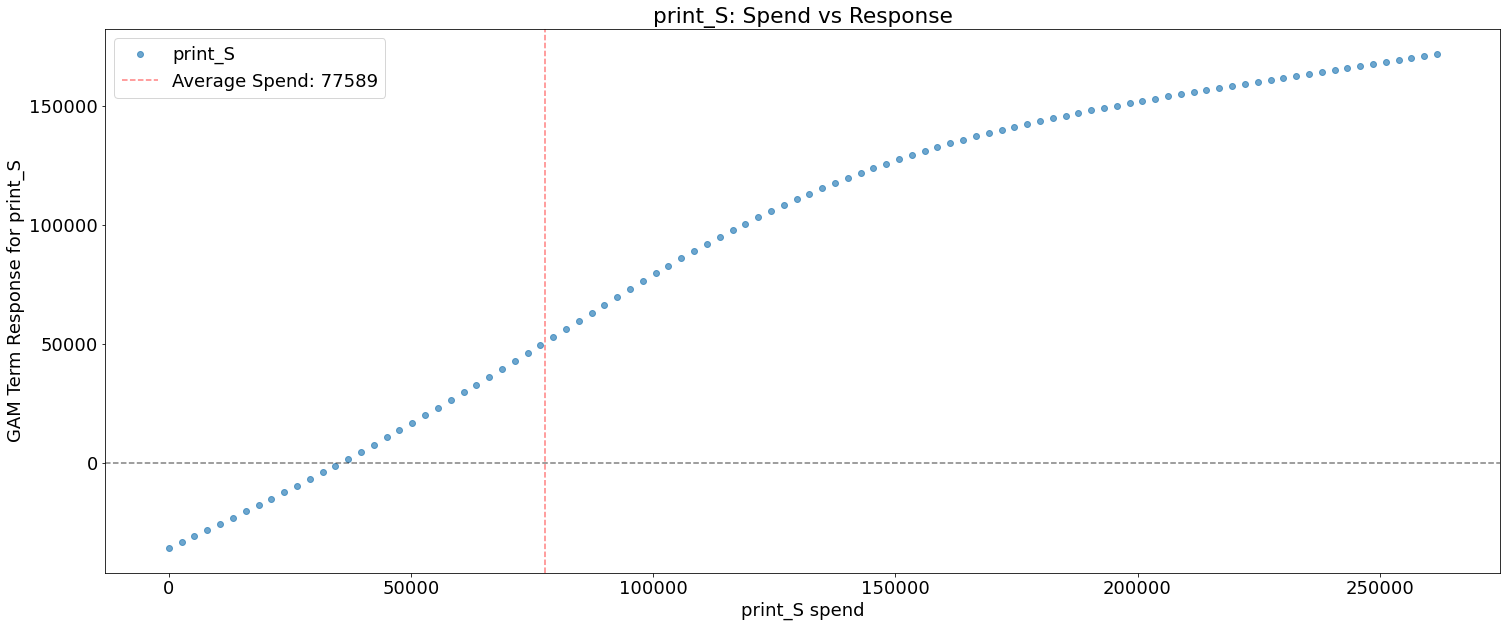

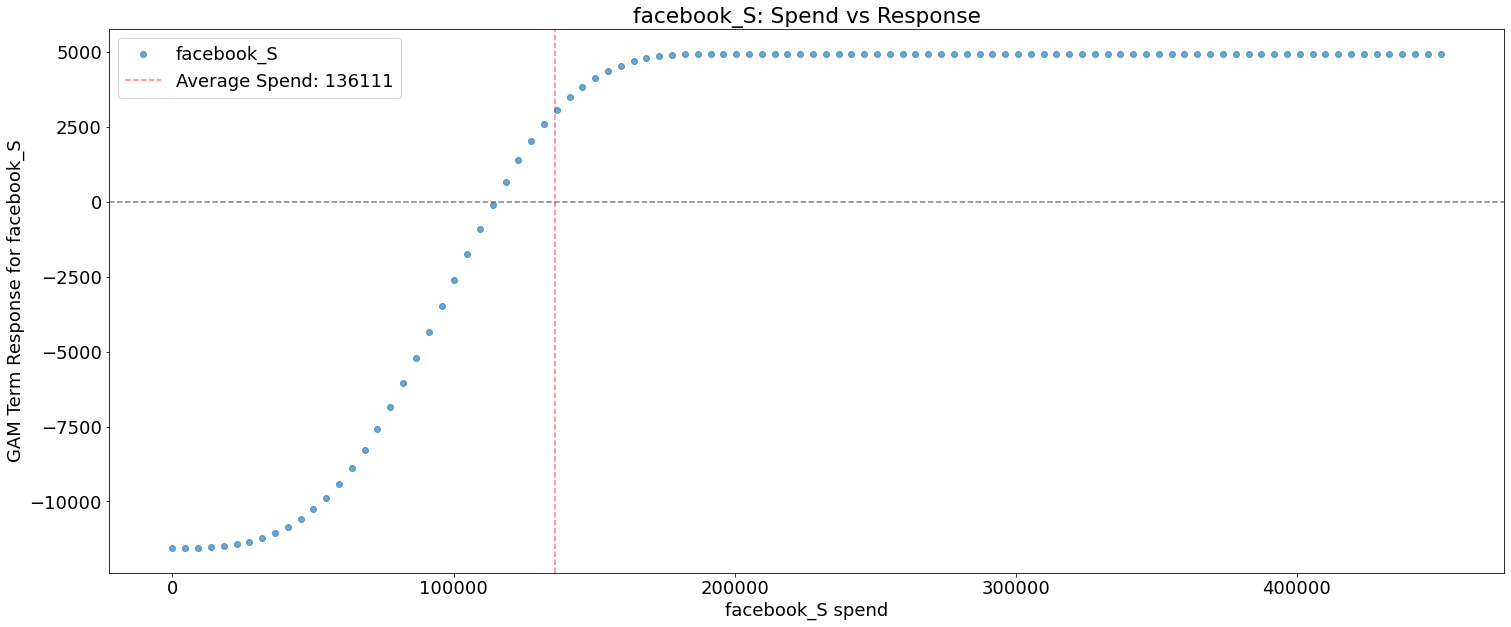

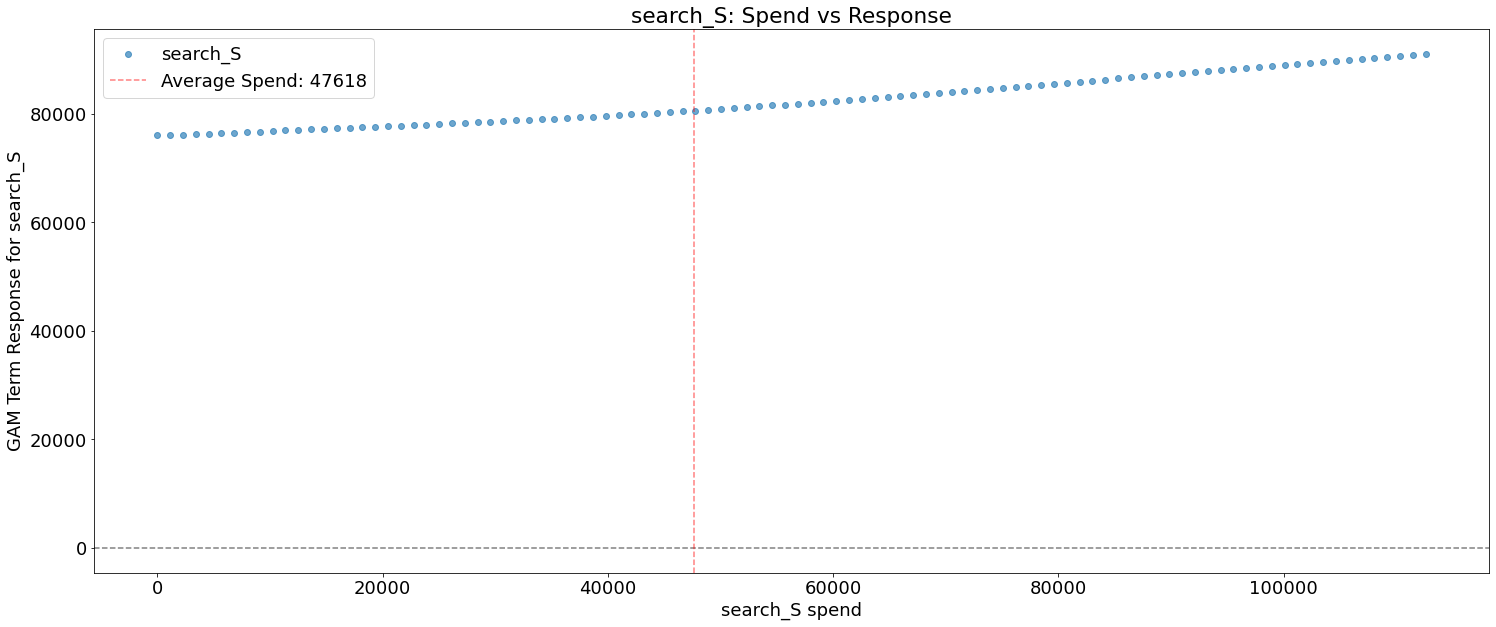

In [284]:
plot_gam_response_vs_spend(result["gam_term_response_values"], result["x_input_interval_nontransformed"], result["x_input_interval_transformed"], features, media_channels)

## Effect of each media channel on response in one graph

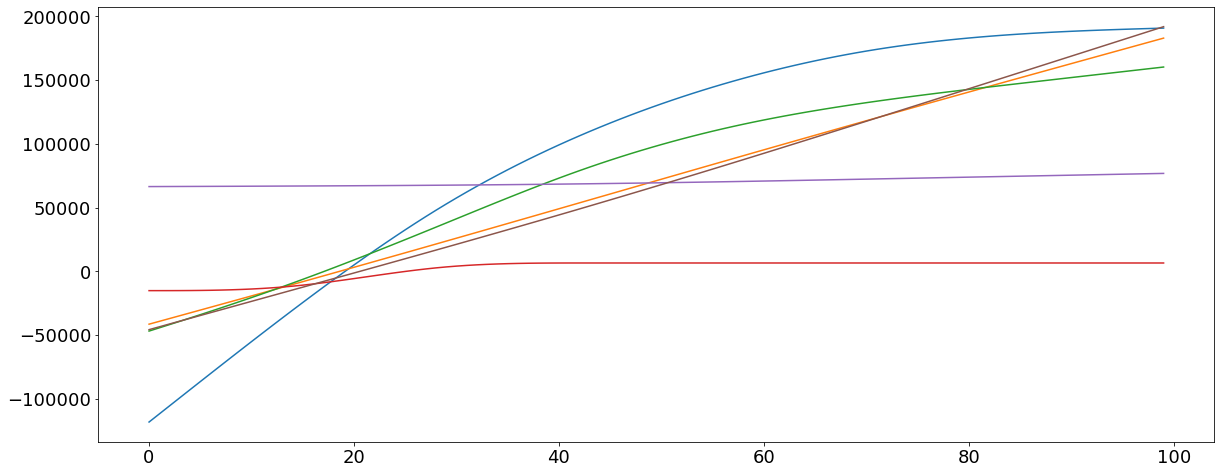

In [244]:

plt.rcParams['figure.figsize'] = (20, 8)
plt.figure()

#iterate through pyGAM terms
#show only Splines
for i, term in enumerate(result["model"].terms):
    
    if term.isintercept:
        continue
        
    if isinstance(term, SplineTerm):
        plt.plot(result["model"].partial_dependence(term = i))